In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
def preprocess(df):
    listIntToBool = ['AU7', 'AU20', 'looking_away']
    for col in listIntToBool:
        df[col] = df[col].astype('bool')
        
    listBB = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
    listLandmarks = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
    listTime = ['Timestamp']
    
    listAUDiff = ['AU1_diff','AU2_diff','AU4_diff','AU5_diff','AU6_diff','AU7_diff','AU9_diff','AU10_diff','AU11_diff','AU12_diff',
                'AU14_diff','AU15_diff','AU17_diff','AU20_diff','AU23_diff','AU24_diff','AU25_diff','AU26_diff','AU28_diff','AU43_diff']
    listEmoDiff = ['disgust_diff','fear_diff','happiness_diff', 'anger_diff', 'sadness_diff','surprise_diff','neutral_diff','emotion_mirroring_diff']
    
    listEyes = ['eyeWidth', 'eyeHeight', 'mean_EAR', 'mean_pupil_ratio']
    
    listAU = ['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU11',
              'AU12','AU14','AU15','AU17','AU20','AU23','AU24','AU25','AU26','AU28','AU43']
    
    ##      + listEmoDiff 
    totalcolumns = listBB + listLandmarks + listTime  + listEyes + listAU 
        
    df = df.drop(columns = totalcolumns)
    df = df[df['Label'] != 'x']
    df = df[df['Label'] != 'skip']
    df['Label'] = df['Label'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    df = df.drop(columns=['pupil_direction', 'Person'])
    
    return df

def create_chunks(df, chunk_size):
    columnlist = ['EAR']
    df_new = pd.DataFrame()
    current_chunk = []
    start_of_probe = -1

    for _, row in df.iterrows():
        if start_of_probe < 0 or (row['Frame'] - start_of_probe) >= 500:
            # Finalize the current chunk, if there is one
            if current_chunk:
                chunk_df = pd.DataFrame(current_chunk)
                chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
                for col in columnlist:  # calculate quartiles and standard deviation for columns in columnlist
                    chunk_summary.update({
                        f'{col}_Q1': chunk_df[col].quantile(0.25),
                        f'{col}_Q2': chunk_df[col].median(),
                        f'{col}_Q3': chunk_df[col].quantile(0.75),
                        f'{col}_SD': chunk_df[col].std(),
                    })
                chunk_summary['Label'] = chunk_df['Label'].values[-1]
                df_new = df_new.append(chunk_summary, ignore_index=True)

            # Start a new probe and a new chunk
            start_of_probe = row['Frame']
            current_chunk = [row]
        elif len(current_chunk) == chunk_size:
            # We have a complete chunk, so finalize it
            chunk_df = pd.DataFrame(current_chunk)
            chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
            for col in columnlist:  # calculate quartiles and standard deviation for columns in columnlist
                chunk_summary.update({
                    f'{col}_Q1': chunk_df[col].quantile(0.25),
                    f'{col}_Q2': chunk_df[col].median(),
                    f'{col}_Q3': chunk_df[col].quantile(0.75),
                    f'{col}_SD': chunk_df[col].std(),
                })
            chunk_summary['Label'] = chunk_df['Label'].values[-1]
            df_new = df_new.append(chunk_summary, ignore_index=True)
            current_chunk = [row]
        else:
            # Add the current row to the current chunk
            current_chunk.append(row)
            
    # Finalize the last chunk, if there is one
    if current_chunk:
        chunk_df = pd.DataFrame(current_chunk)
        chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
        for col in columnlist:  # calculate quartiles and standard deviation for columns in columnlist
            chunk_summary.update({
                f'{col}_Q1': chunk_df[col].quantile(0.25),
                f'{col}_Q2': chunk_df[col].median(),
                f'{col}_Q3': chunk_df[col].quantile(0.75),
                f'{col}_SD': chunk_df[col].std(),
            })
        chunk_summary['Label'] = chunk_df['Label'].values[-1]
        df_new = df_new.append(chunk_summary, ignore_index=True)

    return df_new

def preprocess_and_chunk(filename, chunk_size):
    df = pd.read_csv(filename)
    mean_value = df['EAR'].iloc[:1000].mean()
    df['calibrated_EAR'] = mean_value
    df['pupil_deviation'] = abs(df['mean_pupil_ratio'] - df['pupil_ratio'])
    df['EAR_deviation'] = abs(df['EAR'] - df['calibrated_EAR'])
    df = preprocess(df)
    df_chunks = create_chunks(df, chunk_size)
    df_chunks = df_chunks.drop(columns='calibrated_EAR')
    return df_chunks

def checkForFullYes(filename):
    df = pd.read_csv(filename)
    counts = df['Label'].value_counts()
    no_count = counts.get('no', 0)
    n_count = counts.get('n', 0)
    finalcount = no_count + n_count
    #print(filename, finalcount)
    return finalcount

In [4]:
# filenames = [f"finaldata/{i}.csv" for i in range(1, 29)]  # ["1.csv", "2.csv", ..., "12.csv"]
# dataframes = []

# chunkBool = True
# chunk_size = 25  

# if chunkBool:
#     for filename in filenames:
#         # finalcount = checkForFullYes(filename)
#         # if finalcount == 0:
#         #     continue
#         chunked_df = preprocess_and_chunk(filename, chunk_size)
#         dataframes.append(chunked_df)
    
# else:
#     for filename in filenames:
#         df = pd.read_csv(filename)
#         preprocessed_df = preprocess(df)
#         dataframes.append(preprocessed_df)

    
# combined_df = pd.concat(dataframes, ignore_index=True)
# X = combined_df.drop(columns=['Label', 'Frame'])
# y = combined_df['Label']

filenames = [f"finaldata_750/{i}.csv" for i in range(1, 29)]  # ["1.csv", "2.csv", ..., "28.csv"]

# Specify which files you want for testing.
test_indices = [5, 11, 23, 17, 8]  # Adjust these numbers based on your needs

train_filenames = [f for i, f in enumerate(filenames, start=1) if i not in test_indices]
test_filenames = [f for i, f in enumerate(filenames, start=1) if i in test_indices]

dataframes_train = []
dataframes_test = []

chunkBool = True
chunk_size = 25  

if chunkBool:
    for filename in train_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue        
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_train.append(chunked_df)
    
    for filename in test_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue          
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_test.append(chunked_df)
else:
    for filename in train_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_train.append(preprocessed_df)

    for filename in test_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_test.append(preprocessed_df)
    

train_combined_df = pd.concat(dataframes_train, ignore_index=True)
X_train = train_combined_df.drop(columns=['Label', 'Frame'])
y_train = train_combined_df['Label']

test_combined_df = pd.concat(dataframes_test, ignore_index=True)
X_test = test_combined_df.drop(columns=['Label', 'Frame'])
y_test = test_combined_df['Label']


In [5]:
y_test.value_counts()

## 1.0    4859
## 0.0    1088    
## 1088 / (4859 + 1088) = 0.1829

# 1.00    1165
# 0.00     189

1.0    1700
0.0     278
Name: Label, dtype: int64

In [6]:
smote = SMOTE(random_state=42)


In [7]:
# ## 2a. If preserving the temporal nature of the data is crucial:
# train_size = int(0.8 * len(X))  # 80% train, 20% test
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# ## 2b. If shuffling the data is not a problem:
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# ## Set a random seed for reproducibility
# random_seed = 42

# ## Randomly shuffle X_train and y_train
# X_train = X_train.sample(frac=1, random_state=random_seed)
# y_train = y_train.sample(frac=1, random_state=random_seed)

In [8]:
print(len(y_train))

7338


In [9]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [10]:
from imblearn.under_sampling import NearMiss

smoteBool = 0
undersampleBool = 0

if smoteBool:
    print('SMOTE xgboost')
    X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)  # Adjust hyperparameters as needed
    model.fit(X_train_smote, y_train_smote)
elif undersampleBool:
    print('UNDERSAMPLE xgboost')
    nm = NearMiss()
    X_train_filled, y_train = nm.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)
else:
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)


REGULAR xgboost, scale_weight:0.24774698180581534


In [11]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features
scaler = StandardScaler()
# Create a pipeline: standardize, then run SVM
svm_clf = make_pipeline(scaler, svm.SVC(class_weight='balanced', random_state=42, probability=1))

# Fit the SVM model
if smoteBool:
    svm_clf.fit(X_train_smote, y_train_smote)
    y_pred_svm = svm_clf.predict(X_test_filled)
else:
    svm_clf.fit(X_train_filled, y_train)
    y_pred_svm = svm_clf.predict(X_test_filled)


In [12]:
y_pred = model.predict(X_test_filled)
print('--------- XGB ------------')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print('------------SVM-------------')
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)


print('------------XGB-PROBA--------------')
y_pred_proba = model.predict_proba(X_test_filled)[:,1]

auroc = roc_auc_score(y_test, y_pred_proba)

print("AUROC: %.2f" % auroc)

## best = 0.27 f1 met svm
## auroc = 0.68


## 21 15

--------- XGB ------------
Accuracy: 80.03%
              precision    recall  f1-score   support

         0.0       0.23      0.17      0.20       278
         1.0       0.87      0.90      0.89      1700

    accuracy                           0.80      1978
   macro avg       0.55      0.54      0.54      1978
weighted avg       0.78      0.80      0.79      1978

Confusion Matrix:
[[  48  230]
 [ 165 1535]]
------------SVM-------------
Accuracy: 62.39%
              precision    recall  f1-score   support

         0.0       0.22      0.65      0.33       278
         1.0       0.92      0.62      0.74      1700

    accuracy                           0.62      1978
   macro avg       0.57      0.64      0.53      1978
weighted avg       0.82      0.62      0.68      1978

Confusion Matrix:
[[ 181   97]
 [ 647 1053]]
------------XGB-PROBA--------------
AUROC: 0.64


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


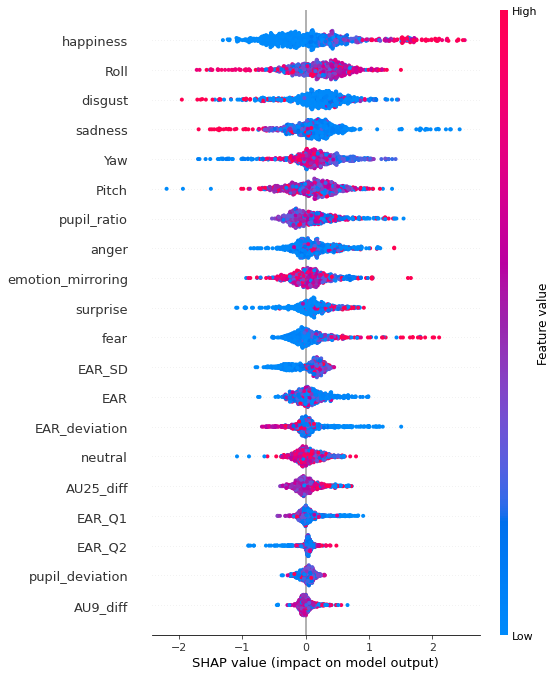

In [13]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Define the number of samples you want
num_samples = 750

# Calculate Shap values
if smoteBool:
    print('smote')
    sample = X_train_smote.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample)
else:
    sample = X_train_filled.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample)


In [14]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_smote, X_test_filled, y_train_smote, y_test)

# Prints the model performance
print(models)

 86%|████████▌ | 25/29 [01:10<00:11,  2.81s/it]


KeyboardInterrupt: 

In [ ]:
# ###Create a background dataset (you can also use a subset of your train dataset)
# background_data = X_train_filled.iloc[90:93,:]

# ###Use KernelExplainer for SVM
# explainer = shap.KernelExplainer(svm_clf.predict_proba, background_data)

# ###Calculate shap_values for all of X
# shap_values = explainer.shap_values(X_test_filled)

# ###Plot the SHAP values
# shap.summary_plot(shap_values, X_test_filled)


Accuracy: 61.60%
              precision    recall  f1-score   support

         0.0       0.22      0.68      0.33       189
         1.0       0.92      0.61      0.73      1165

    accuracy                           0.62      1354
   macro avg       0.57      0.64      0.53      1354
weighted avg       0.82      0.62      0.67      1354



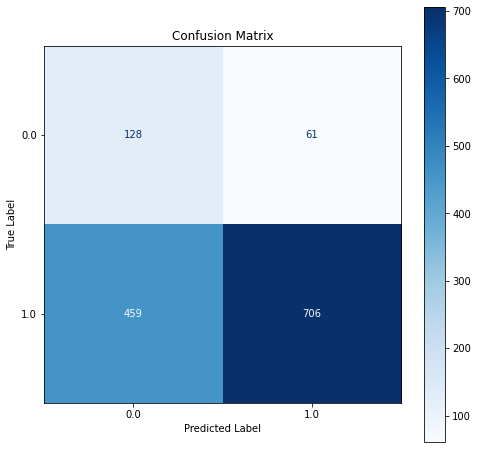

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
y_test.value_counts()

1.00    1165
0.00     189
Name: Label, dtype: int64

In [ ]:
y_test.value_counts()

1.00    1165
0.00     189
Name: Label, dtype: int64

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4],
    'min_child_weight': [1, 3],
    'gamma': [0.1, 0.01, 0.05],
    'subsample': [0.4,0.6],
    'colsample_bytree': [0.3, 0.8],
}

# Create an XGBoost classifier with default parameters
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

# Define the scoring metric (F1-score)
scoring = make_scorer(f1_score)

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring=scoring,
    cv=2,  # You can use more folds if needed
    verbose=2,
    n_jobs=-1,
)

if smoteBool:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train_filled, y_train)


# Get the best parameters and the corresponding best F1-score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best F1-score: ", best_f1_score)

# Train and evaluate the XGBoost model with the best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
if smoteBool:
    best_xgb_model.fit(X_train_smote, y_train_smote)
    y_pred = best_xgb_model.predict(X_test_filled)
else:
    best_xgb_model.fit(X_train_filled, y_train)
    y_pred = best_xgb_model.predict(X_test_filled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 432 candidates, totalling 864 fits
Best Parameters:  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.4}
Best F1-score:  0.6951075757214904
Accuracy: 85.82%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       189
         1.0       0.86      1.00      0.92      1165

    accuracy                           0.86      1354
   macro avg       0.43      0.50      0.46      1354
weighted avg       0.74      0.86      0.79      1354

